In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from ignite.engine import create_supervised_trainer, create_supervised_evaluator, Engine
from ignite.metrics import Accuracy, Loss, Precision, Recall
from ignite.engine import Events
from IPython.display import clear_output
from datetime import timedelta
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
print(device)

cpu


In [2]:
with open('input_data.csv', 'r') as file:
    df = pd.read_csv(file, delimiter='\t', decimal = ',')
df.head(5)

,Date,series1
0,2015-01-01,1006.7
1,2015-01-02,3197.8
2,2015-01-03,3217.5
3,2015-01-04,2151.6
4,2015-01-05,4243.9


Conduct small analysis of this dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     1642 non-null   object 
 1   series1  1642 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.8+ KB


Column names are corrected accordingly to pep-8 format

In [4]:
df.columns = list(map(lambda x: x.lower().replace(' ', '_'),list(df.columns)))
df.columns

Index(['date', 'series1'], dtype='object')

Change the values in Date column to datetime object

In [5]:
def to_datetime(row):
    date_format = '%Y-%m-%d'
    if not isinstance(row, pd.Timestamp):
        return datetime.strptime(row, date_format)
    else:
        return row
df['date'] = df['date'].apply(lambda x: to_datetime(x))

In [6]:
def draw_line_plot():
    figure, ax = plt.subplots(nrows=1,ncols=1,figsize = (30,20))
    sns.lineplot(data = df, x='date',y='series1', ax = ax)
    plt.show()

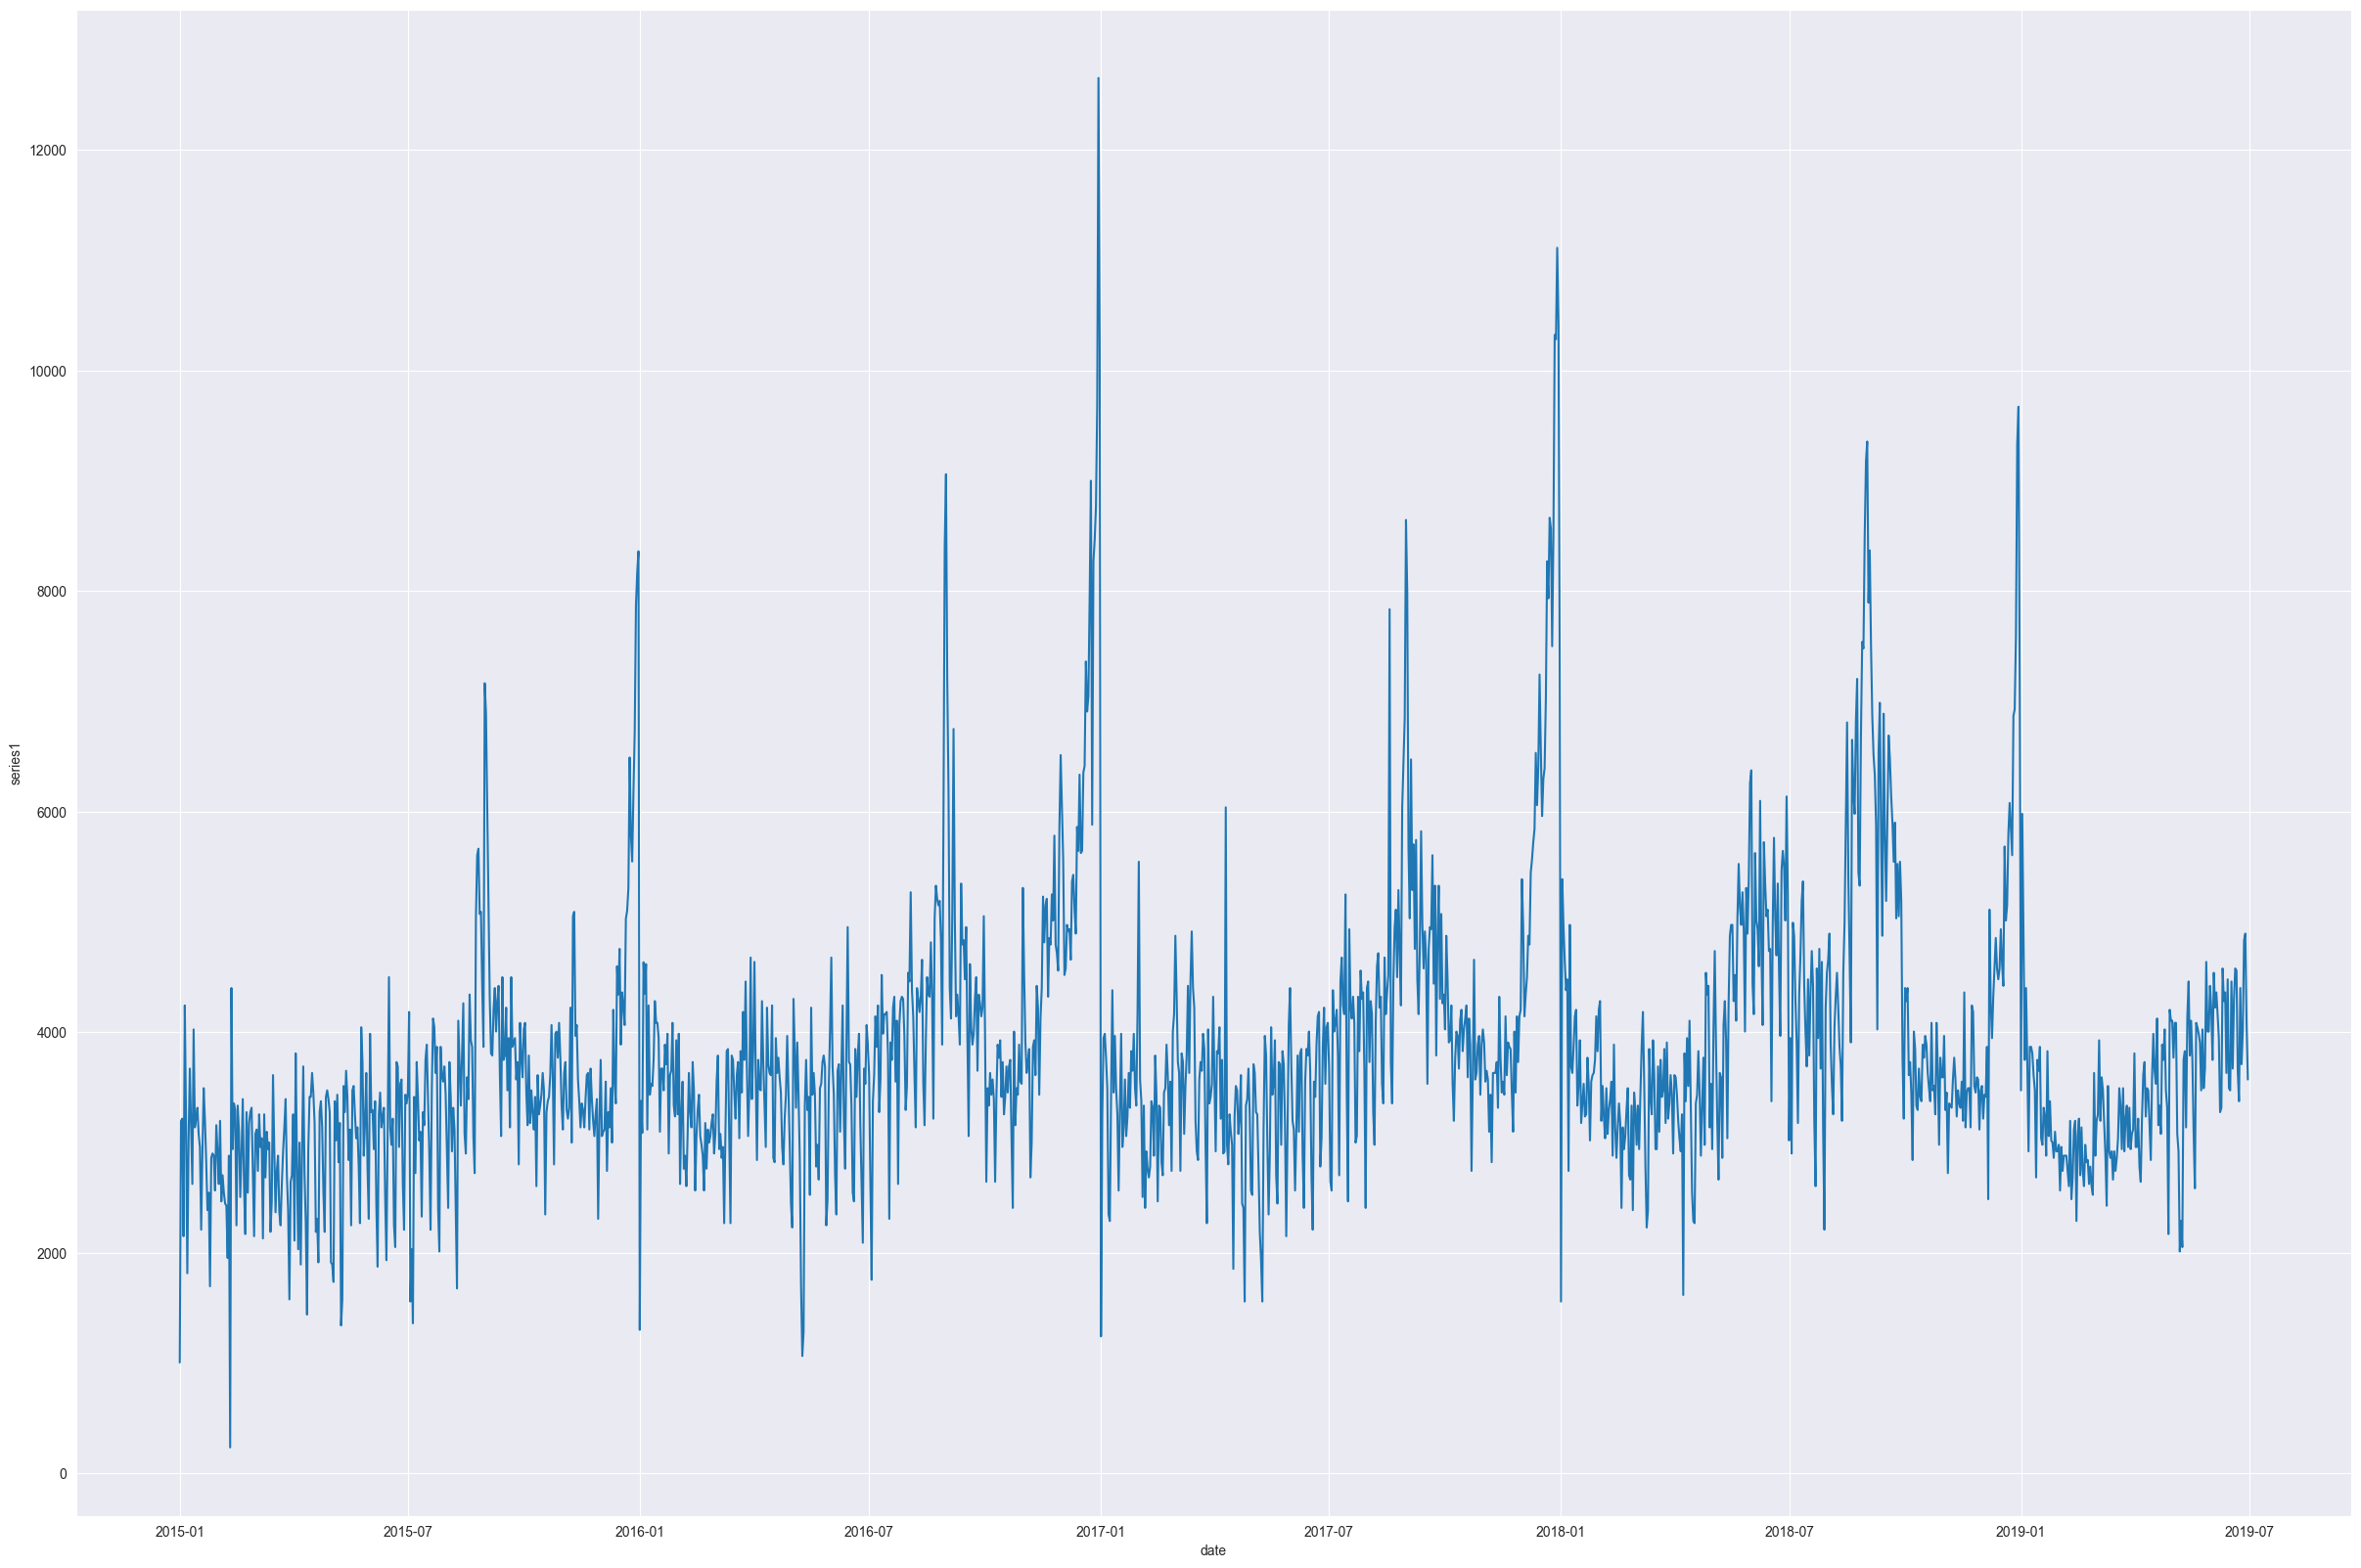

In [7]:
draw_line_plot()

Data preprocessing - replace extremal values with the median
extra big values > 10000
extra small values < 2000

In [8]:
def define_extremals(row):
    if row['series1']< 2000 or row['series1'] > 10000:
        median_val = df[df['date'].dt.year==2015]['series1'].median()
        return median_val
    else: 
        return row['series1']

In [9]:
df['series1'] = df.apply(lambda x: define_extremals(x), axis = 1)

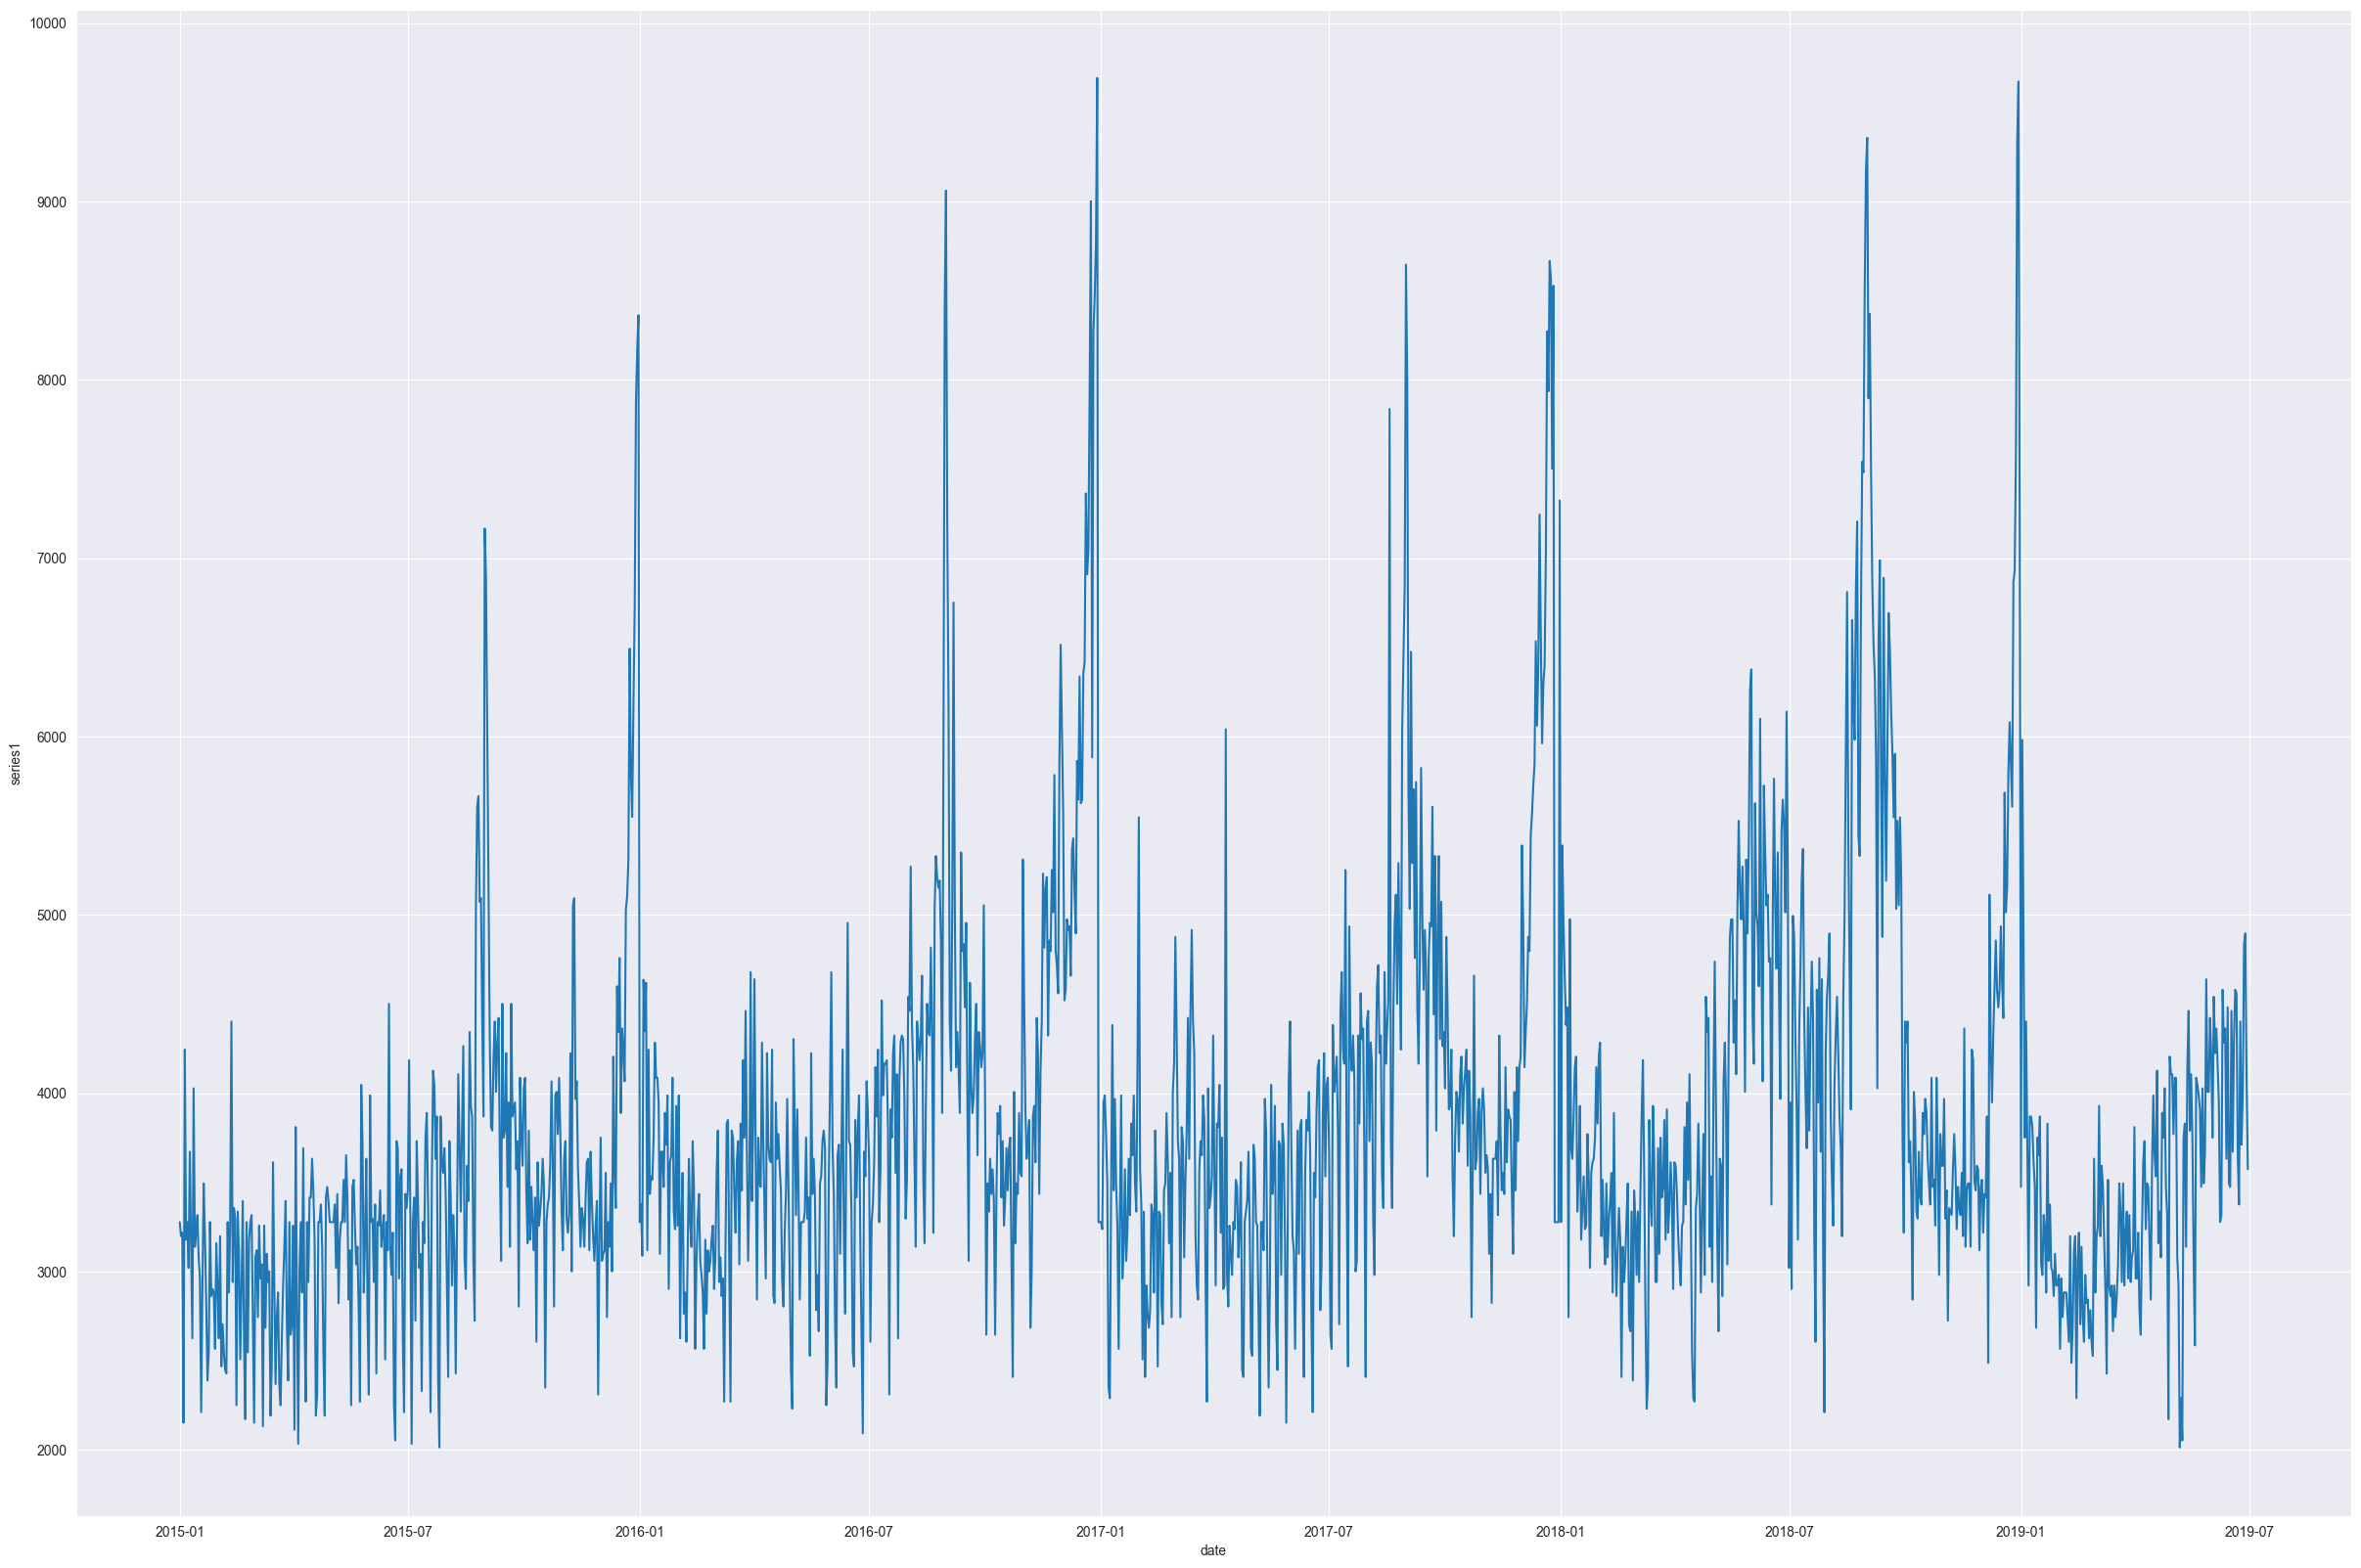

In [10]:
draw_line_plot()

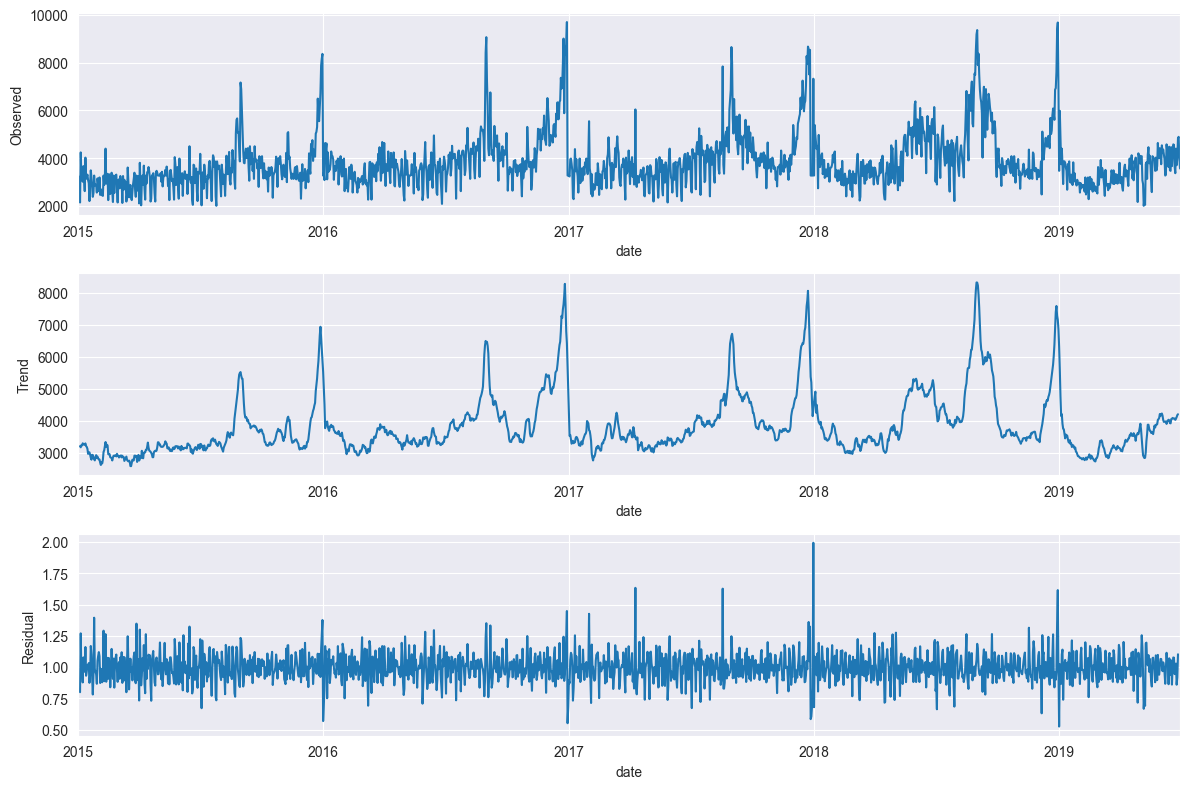

In [11]:
new_df = df.copy()
new_df.set_index('date', inplace=True)

result = seasonal_decompose(new_df['series1'], model='multiplicative')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))

result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

result.resid.plot(ax=ax3)
ax3.set_ylabel('Residual')

plt.tight_layout()
plt.show()

Now we will try 2 different architectures:
1. using pytorch
2. using ARIMA pre-defined model

## Pytorch implemetation

In [12]:
# using proportion 80 : 20 we split our dataset
train_data_len = round(df.shape[0] * .8)
train_df, test_df = df[:train_data_len], df[train_data_len:]
dataset_train, dataset_test = train_df.series1.values,test_df.series1.values
dataset_train, dataset_test = np.reshape(dataset_train, (-1, 1)), np.reshape(dataset_test, (-1, 1))

In [13]:
# minmax scaling to obtain adequate values
scaler = MinMaxScaler(feature_range=(0,1))
scaler_train, scaler_test = scaler.fit_transform(dataset_train), scaler.fit_transform(dataset_test)
scaler_test[:5]

array([[0.30154855],
       [0.32989502],
       [0.28866141],
       [0.24227033],
       [0.21906826]])

Transforming the data into Sequence

In [14]:
def sequence_transforming(seq_length, data):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+1:seq_length+1+i])
    X, y = np.array(X), np.array(y)
    return X,y

# choose the number of steps to look back to
sequence_length_train = 50
sequence_length_test = 30

X_train, y_train = sequence_transforming(sequence_length_train, scaler_train)
X_test, y_test = sequence_transforming(sequence_length_test, scaler_test)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

Define LSTM class model

In [15]:
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.0):
        super(LSTM_model, self).__init__()
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        
        # Define additional fully connected layers
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        
        # Define a dropout layer (optional)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # Get the LSTM outputs
        lstm_out, _ = self.lstm(x)
        # Pass through additional fully connected layers for each time step
        x = torch.relu(self.fc1(lstm_out))
        x = self.dropout(x)  # Apply dropout
        out = self.fc2(x)
        return out


* input_size: The number of expected features in the input x.
* hidden_size: The number of features in the hidden state h.
* num_layers: Number of recurrent layers. E.g., setting num_layers=2 means stacking two LSTMs to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results.
* dropout: If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to this value.
* batch_first: If True, then the input and output tensors are provided as (batch, seq, feature). Default is False, which would expect input tensors in the form of (seq, batch, feature).

Defining hyperparameters and loss type

In [16]:
input_size, output_size = 1, 1
hidden_size = 256
num_layers = 3
model = LSTM_model(input_size, hidden_size, num_layers).to(device)
loss = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

LSTM_model(
  (lstm): LSTM(1, 256, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)


Creating Data Loader for batch training

In [17]:
batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = batch_size)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size = batch_size)

Model Training & Evaluation

In [27]:
epochs = 15
train_loss, test_loss = [], []

Results after Train epoch: Loss:0.002487557221062576
Results after Test epoch: Loss:0.01320664914662406


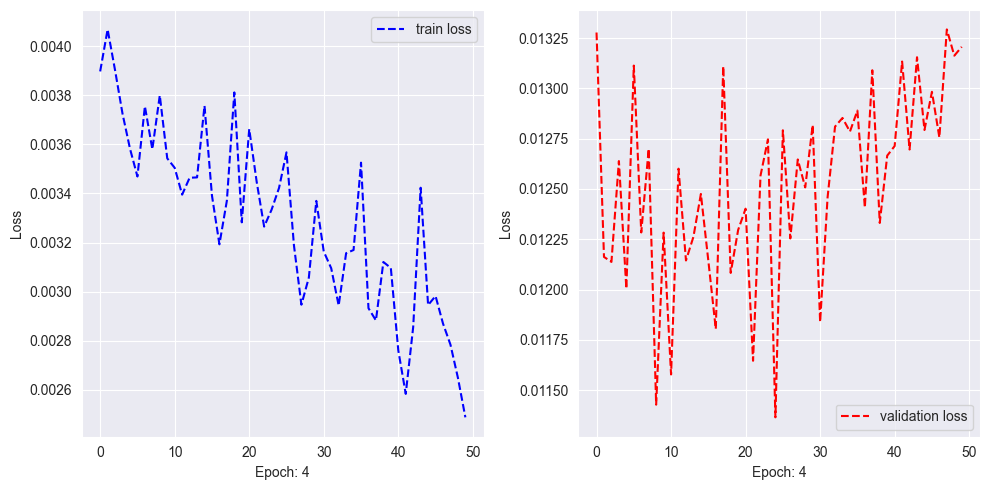

In [36]:
for epoch in range(epochs):

    # illustration
    def draw_plots(train_loss, test_loss):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
        # Train loss plot
        axes[0].plot(np.array(train_loss), color='blue', linestyle='--', label='train loss')
        axes[0].set_ylabel('Loss')
        axes[0].set_xlabel(f'Epoch: {epoch}')
        axes[0].legend()
    
        # Validation loss plot
        axes[1].plot(np.array(test_loss), color='red', linestyle='--', label='validation loss')
        axes[1].set_ylabel('Loss')
        axes[1].set_xlabel(f'Epoch: {epoch}')
        axes[1].legend()
    
        plt.tight_layout()
        plt.show()


    def one_epoch(engine):
        train_eval.run(train_loader)
        test_eval.run(test_loader)
        train_results = train_eval.state.metrics
        test_results = test_eval.state.metrics
        # Ensure 'Loss' is accessed correctly
        if 'Loss' in train_results:
            train_loss.append(train_results['Loss'])
        if 'Loss' in test_results:
            test_loss.append(test_results['Loss'])


        draw_plots(train_loss, test_loss)

    def print_epoch_results(engine, type_train_eval=""):
        result = "\t".join([f"{i}:{j}" for i, j in engine.state.metrics.items()])
        print(f"Results after {type_train_eval} epoch:", result)

    def clear_output_handler(engine):
        clear_output(wait=True)
    # Create trainers and evaluators
    trainer = create_supervised_trainer(model, optimizer, loss, device)
    metrics_for_task = {"Loss": Loss(loss)}
    train_eval = create_supervised_evaluator(model, device=device, metrics=metrics_for_task)
    test_eval = create_supervised_evaluator(model, device=device, metrics=metrics_for_task)

    # Event handlers
    trainer.add_event_handler(Events.EPOCH_COMPLETED, one_epoch)
    trainer.add_event_handler(Events.EPOCH_COMPLETED, clear_output_handler)
    train_eval.add_event_handler(Events.EPOCH_COMPLETED, print_epoch_results, type_train_eval="Train")
    test_eval.add_event_handler(Events.EPOCH_COMPLETED, print_epoch_results, type_train_eval="Test")

    # Run the trainer
    print(f'Epoch {epoch} from {epochs}')
    trainer.run(train_loader, max_epochs=epochs)

In [37]:
torch.save(model.state_dict(), "model_saved.mdl")

Forecasting 

In [38]:
if device == 'cuda:0':
    model.load_state_dict(torch.load("model_saved.mdl"))
else:
    model_state_dict = torch.load("model_saved.mdl", map_location=torch.device('cpu'))

In [39]:
def predict_values(data_):
    #  to store predicted values 
    forecasted = []
    # do not change the model features
    with torch.no_grad():
        for _ in range(60): 
            # Prepare the historical_data tensor
            hist_data_tensor = torch.as_tensor(data_).view(1, -1, 1).float().to(device)
    #       predict the next value 
            predicted = model(hist_data_tensor).cpu().numpy()[0, 0]
            # append value to plot
            forecasted.append(predicted[0])
            # delete preceding value and replace it with the forecasted 
            data_ = np.roll(data_, shift=-1)
            data_[-1] = predicted
    return forecasted

In [40]:
# defining number of steps
future_steps_num = 30
# Convert to NumPy and remove singleton dimensions
sequence = X_test.squeeze().cpu().numpy()
#  using the last 30 points as a starting 
hist_data = sequence[-1]
forecasted = predict_values(data_ = hist_data)

/var/folders/5z/q8bm192908s5bxspy3h_17mr0000gn/T/ipykernel_18948/3523785922.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_[-1] = predicted


In [41]:
combined_index = test_df.date[-30:]

forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted[:30], axis=0)).flatten() 
answer = pd.DataFrame({'date': combined_index, 'series1': forecasted_cases})

In [42]:
# Reverse the scaling transformation
original_cases = scaler.inverse_transform(np.expand_dims(sequence[-1], axis=0)).flatten()

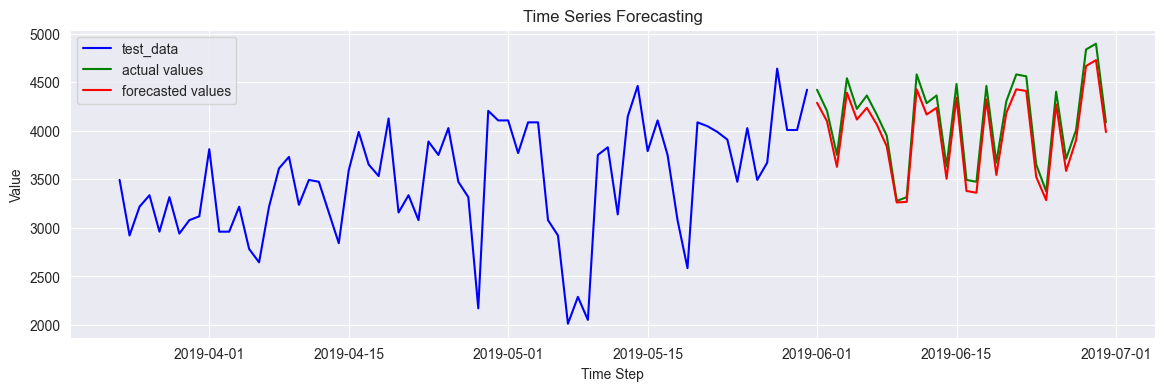

In [43]:
plt.rcParams['figure.figsize'] = [14, 4]

# Test data
plt.plot(test_df.date[-100:-30], test_df.series1[-100:-30], label="test_data", color="b")

# The historical data used as input for forecasting
plt.plot(test_df.date[-30:], original_cases, label='actual values', color='green')

# Forecasted Values
plt.plot(answer.date, forecasted_cases, label='forecasted values', color='red')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)

plt.show()

Let's generate some more dates and predict the trend for them

In [44]:
last_date, last_values = answer['date'], answer['series1']
last_values_np = last_values.to_numpy()

last_values_tensor = torch.tensor(last_values_np, dtype=torch.float32)

last_values_np_reshaped = last_values_tensor.numpy().reshape(-1, 1)


scaled_last_values_np = scaler.fit_transform(last_values_np_reshaped)


scaled_last_values_tensor = torch.tensor(scaled_last_values_np, dtype=torch.float32)
last_values = scaled_last_values_tensor.squeeze().cpu().numpy()

In [45]:
# reforming predictions
predicted_data = np.array(predict_values(data_ = last_values))
predicted_data = scaler.inverse_transform(np.expand_dims(predicted_data, axis=0)).flatten()

/var/folders/5z/q8bm192908s5bxspy3h_17mr0000gn/T/ipykernel_18948/3523785922.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_[-1] = predicted


In [46]:
new_dates_list = []
last_day = last_date.max()
for i in range(1, 61):
    new_dates_list.append((last_day + timedelta(days=i)).strftime('%Y-%m-%d')) 

final_ans = pd.DataFrame({'date': new_dates_list, 'series1': predicted_data})

final_ans['date'] = pd.to_datetime(final_ans['date'])

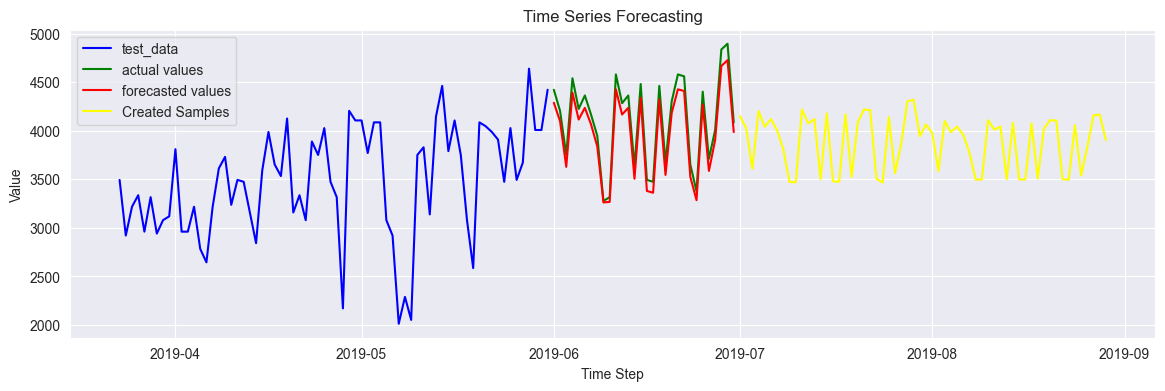

In [47]:
plt.plot(test_df.date[-100:-30], test_df.series1[-100:-30], label="test_data", color="b")
plt.plot(test_df.date[-30:], original_cases, label='actual values', color='green')
plt.plot(answer.date, forecasted_cases, label='forecasted values', color='red')
plt.plot(final_ans.date, final_ans.series1, label='Created Samples', color='yellow')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)

plt.show()